In [2]:
# Common imports
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import os, shutil
from os import listdir
from PIL import Image

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation,MaxPooling2D,Dropout
from tensorflow.keras.applications import ResNet152,InceptionV3

from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing** 

##### Method to convert 3D RGB image to 2D gray scale image

In [4]:
## Method to convert a 3D RGB image to 2D gray scale image
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

##### Method to load images and add to a numpy array

In [5]:
## Method to load images and add to a numpy array
def load_images_to_np_array(images_dir):
    images_dir = Path(images_dir).expanduser()
    dim = (256, 256)
    # Resizing all the images to same dimension
    images = []
    for fname in listdir(images_dir):
        fpath = os.path.join(images_dir, fname)
        im = Image.open(fpath)
        im_resized = im.resize(dim)
        images.append(im_resized)

    ## Converting the image to numpy array
    images_arr=[]
    for x in range(len(images)):
        image=np.array(images[x])
        image = to_grayscale(image)
        images_arr.append(image)
    return images_arr

In [6]:
orig_images_folders = [ 'drive/My Drive/data/orig/orig adidas', 'drive/My Drive/data/orig/orig puma', 'drive/My Drive/data/orig/orig nike']
orig_image_data = []
for folder in orig_images_folders:
    orig_images_arr = load_images_to_np_array(folder)
    for i in range(0,len(orig_images_arr)):
        orig_image_data.append([orig_images_arr[i],'orig'])
    

In [7]:
# Converting Original Images list into pandas dataframe
orig_df = pd.DataFrame(orig_image_data)
orig_df = orig_df.rename(columns={0: 'Images',1:'Labels'}) #rename pandas dataframe column names
orig_df.head(2)

,Images,Labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",orig
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",orig


In [8]:
fake_images_folders = ['drive/My Drive/data/fake/fake adidas', 'drive/My Drive/data/fake/fake puma', 'drive/My Drive/data/fake/fake nike']
fake_image_data = []
for folder in fake_images_folders:
    fake_images_arr = load_images_to_np_array(folder)
    for i in range(0,len(fake_images_arr)):
        fake_image_data.append([fake_images_arr[i],'fake'])

In [9]:
# Converting Fake Images list into pandas dataframe
fake_df = pd.DataFrame(fake_image_data)
fake_df = fake_df.rename(columns={0: 'Images',1:'Labels'}) #rename pandas dataframe column names
fake_df.head(2)

,Images,Labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",fake
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",fake


In [10]:
## Merging original and fake images dataframes
frames = [orig_df, fake_df]
data = pd.concat(frames)
data.reset_index(inplace=True)
print(data.shape)

(1631, 3)


In [11]:
X, y = data["Images"], data["Labels"]
print(type(X), type(y))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [12]:
# Creating Test Set by startified split test size "20%"
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=5,test_size = 0.2,random_state = 42)
print(split)
for train_index,test_index in split.split(data,data["Labels"]):
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)


In [13]:
##Creating Validation Set by startified split test size "20%"
from sklearn.model_selection import train_test_split
X_train_data,X_val_data,y_train_data,y_val_data = train_test_split(train_set["Images"],train_set["Labels"],test_size=0.2,random_state=42)
X_test_data = test_set["Images"]
y_test_data = test_set["Labels"]
print(X_train_data.shape,X_val_data.shape, X_test_data.shape,y_train_data.shape,y_val_data.shape, y_test_data.shape)


(1043,) (261,) (327,) (1043,) (261,) (327,)


##### Method to convert labels to binary format

In [14]:
## Method to convert labels to binary format
def convert_labels_to_binary(data):
    data_new = [0]*len(data)
    for i in range(0,len(data)):
        if data.iloc[i] == 'orig':
            data_new[i] = 1
        else:
            data_new[i] = 0
    return np.array(data_new)

In [15]:
## Converting labels 'orig' and 'fake' to binary 1,0 in all train val and test datasets
y_train = convert_labels_to_binary(y_train_data)
y_val = convert_labels_to_binary(y_val_data)
y_test = convert_labels_to_binary(y_test_data)

In [16]:
#converting each 3d image in a list into 4D tensor array as we need for input to CNN
X_train_new =[0] * len(X_train_data) 
for i in range(0,len(X_train_data)):
    X_train_new[i] = np.reshape((X_train_data.iloc[i]),(256,256,1))

X_train = np.asarray(X_train_new)

X_val_new=[0] * len(X_val_data)
for i in range(0,len(X_val_data)):
    X_val_new[i] = np.reshape((X_val_data.iloc[i]),(256,256,1))
    
X_val = np.asarray(X_val_new)


X_test_list =[0] * len(X_test_data) 
for i in range(0,len(X_test_data)):
    X_test_list[i] = np.reshape((X_test_data.iloc[i]),(256,256,1))

X_test = np.asarray(X_test_list)


# normalising image / scaling down x values from 1-255 to 0-1 scale
X_train = X_train.astype('float32')
X_train /= 255

X_val = X_val.astype('float32')
X_val /= 255

X_test = X_test.astype('float32')
X_test /= 255


## **Model building**

In [17]:
np.random.seed(42)

In [42]:
model = Sequential()
# model = InceptionV3(weights='imagenet', include_top=True)
#add model layers
model.add(Conv2D(50, kernel_size = (3,3),strides=(1,1), padding='same', activation='relu', input_shape=(256,256,1)))
# model.add(Conv2D(64, kernel_size = (3,3),strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(50, kernel_size = (3,3),strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(keras.layers.GaussianNoise(0.1))
# model.add(Conv2D(50, kernel_size = (3,3),strides=(1,1), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(200, activation ='relu'))
# model.add(Dropout(0.2))
model.add(Dense(300, activation ='relu'))
model.add(Dense(300, activation ='relu'))
# model.add(Dense(200, activation ='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [19]:
# model = Sequential()
# #add model layers
# model.add(Conv2D(50, kernel_size = (3,3), padding='same', activation='relu', input_shape=(256,256,1)))
# model.add(Conv2D(50, kernel_size = (3,3), padding='same', activation='relu'))
# model.add(Dense(100, activation ='relu'))
# model.add(Dense(100, activation ='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [43]:
# Compile model
optim = keras.optimizers.SGD(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [45]:
##Early stopping
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
##
##earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
callback = [earlystop]

#fitting model
history =model.fit(X_train, y_train,
              batch_size=150,
              epochs=50,
              validation_data=(X_val, y_val),
              shuffle=True, callbacks=callback)

Epoch 1/50
7/7 [==============================] - 1s 213ms/step - loss: 0.4910 - accuracy: 0.7641 - val_loss: 0.4850 - val_accuracy: 0.7663
Epoch 2/50
7/7 [==============================] - 1s 209ms/step - loss: 0.4251 - accuracy: 0.8025 - val_loss: 0.5060 - val_accuracy: 0.8046
Epoch 3/50
7/7 [==============================] - 1s 211ms/step - loss: 0.5375 - accuracy: 0.7383 - val_loss: 0.4769 - val_accuracy: 0.7893
Epoch 4/50
7/7 [==============================] - 1s 208ms/step - loss: 0.4278 - accuracy: 0.8073 - val_loss: 0.6511 - val_accuracy: 0.7816
Epoch 5/50
7/7 [==============================] - 1s 208ms/step - loss: 0.4562 - accuracy: 0.7843 - val_loss: 0.4376 - val_accuracy: 0.8008
Epoch 6/50
7/7 [==============================] - 1s 208ms/step - loss: 0.4255 - accuracy: 0.8121 - val_loss: 0.4323 - val_accuracy: 0.7893
Epoch 7/50
7/7 [==============================] - 1s 210ms/step - loss: 0.3816 - accuracy: 0.8284 - val_loss: 0.4346 - val_accuracy: 0.8352
Epoch 8/50
7/7 [====

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 50)      500       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      28864     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [46]:
#Evaluating model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

11/11 [==============================] - 0s 19ms/step - loss: 0.0565 - accuracy: 0.9939
Test loss: 0.0565292052924633
Test accuracy: 0.9938837885856628


In [47]:
from sklearn.metrics import confusion_matrix
predictions=(model.predict(X_test) > 0.5).astype("int32")
#Confusion matrix
confusion_matrix(y_test, predictions)

array([[158,   0],
       [  2, 167]])

In [48]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
#F1 Score
print(f1_score(y_test, y_test_pred, average='weighted'))

0.9938848224074122


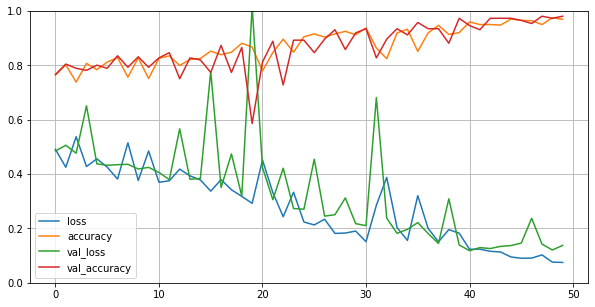

In [49]:

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

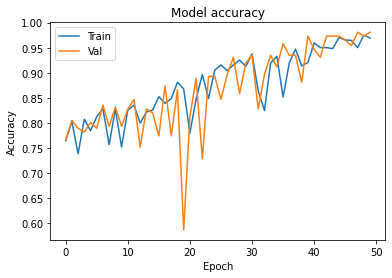

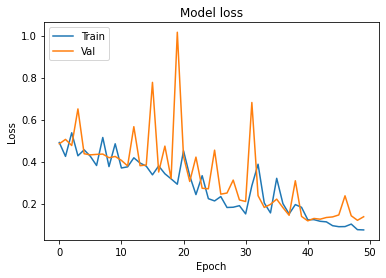

In [50]:

#Learning curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()